# Variational quantum eigensolver (VQE)

**Note**: to run this code you'll have to install the `qchem` module manually: `pip install pennylane-qchem`.

Learning goals:
 
 - construct a Hamiltonian in PennyLane
 - implement the VQE algorithm end-to-end
 - use PennyLane's new sparse Hamiltonian representation to speed up VQE calculations

The VQE is a variational algorithm that can be used to find the ground state energy of a quantum system, such as a molecule.

There are a few things we need to start:

1. Choose an initial state  $|\psi\rangle$ for the system described by a particular Hamiltonian $H$
2. Choose a suitable ansatz circuit $U(\alpha)$
3. Choose a starting set of parameters $\alpha$

To run the algorithm, what we do is:

1. Apply $U(\alpha)$ and measure the output state
2. Use measurement results to compute numerical value of $\langle 0\vert U^\dagger(\alpha)HU(\alpha)\vert 0\rangle$ (the energy)
3. Use some optimization routine to choose a new $\alpha$ that should bring us to a state closer to the ground state.
4. Repeat the above until the optimizer converges to a minimum value, or the number of iterations has exceeded a specified maximum.


## Computing the ground state energy of  the hydrogen molecule

### Constructing a Hamiltonian

PennyLane's [`qchem` module](https://pennylane.readthedocs.io/en/stable/introduction/chemistry.html) contains sophisticated functionality to construct Hamiltonians. You can create them with the [`molecular_hamiltonian()`](https://pennylane.readthedocs.io/en/stable/introduction/chemistry.html#building-the-electronic-hamiltonian) function. The minimum information is a set of symbols (labelling the molecular components), and their coordinates.

(Such symbols and coordinates can also imported from common quantum chemistry formats using the [`read_structure()`](https://pennylane.readthedocs.io/en/stable/introduction/chemistry.html#importing-molecular-structure-data) function).

In [31]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np

symbols = ["H", "H"]
coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 1.323])

H, qubits = qchem.molecular_hamiltonian(symbols, coordinates) # Lots of defaults; maybe mention
print(f"Number of qubits = {qubits}\n")
print(f"H = {H}")

Number of qubits = 4

H =   (-0.24269163652660045) [Z2]
+ (-0.24269163652660045) [Z3]
+ (-0.04222777849645987) [I0]
+ (0.17769651418329502) [Z1]
+ (0.17769651418329507) [Z0]
+ (0.12292717379108761) [Z0 Z2]
+ (0.12292717379108761) [Z1 Z3]
+ (0.16767870129939083) [Z0 Z3]
+ (0.16767870129939083) [Z1 Z2]
+ (0.17059254565342527) [Z0 Z1]
+ (0.17627162608801228) [Z2 Z3]
+ (-0.04475152750830324) [Y0 Y1 X2 X3]
+ (-0.04475152750830324) [X0 X1 Y2 Y3]
+ (0.04475152750830324) [Y0 X1 X2 Y3]
+ (0.04475152750830324) [X0 Y1 Y2 X3]


In [32]:
len(H.terms[0])

15

In [33]:
dev = qml.device('default.qubit', wires=4)

### Choosing an initial state

The hydrogen molecule has 2 electrons, in four orbitals. A good choice for the initial state is called the *Hartree-Fock* state. The Hartree-Fock state can be constructed automatically in PennyLane by passing the number of electrons and number of qubits to the [`hf_state()`](https://pennylane.readthedocs.io/en/stable/code/api/pennylane_qchem.qchem.hf_state.html?highlight=hf_state#pennylane_qchem.qchem.hf_state) function.

In [34]:
electrons = 2
hf = qml.qchem.hf_state(electrons, qubits)
print(hf)

[1 1 0 0]


We make a function to prepare this state using the `BasisState` template:

In [35]:
def initialize_state():
    qml.BasisState(hf, wires=[0, 1, 2, 3])

### Choosing a variational circuit architecture 

The ground state of the hydrogen molecule has the following form - trial state:

\begin{equation}
|\Psi(\theta)\rangle = \cos(\theta/2) |1100\rangle - \sin(\theta/2) |0011\rangle
\end{equation}

This is called a *double excitation* as it involves two of the electrons to be kicked to higher orbitals. In PennyLane, [`SingleExcitation`](https://pennylane.readthedocs.io/en/stable/code/api/pennylane.SingleExcitation.html) and [`DoubleExcitation`](https://pennylane.readthedocs.io/en/stable/code/api/pennylane.DoubleExcitation.html) operators are available.

In [36]:
def variational_circuit(theta):
    qml.DoubleExcitation(theta, wires=[0, 1, 2, 3])

### Putting things together

In [37]:
def vqe_circuit(theta, wires):
    initialize_state()
    variational_circuit(theta)

### Cost function

Now we need to optimize this circuit to find $\theta$ that leads to the lowest energy. We need a cost function and an optimizer.

In [38]:
cost = qml.ExpvalCost(vqe_circuit, H, dev)

opt = qml.GradientDescentOptimizer(stepsize=0.4)

theta = np.array(0.0)

In [39]:
energy_record = [cost(theta)] 
theta_record = [theta]

import time
 
for n in range(20):
    t1 = time.time()
    theta, prev_energy = opt.step_and_cost(cost, theta)
    t2 = time.time()
    energy = cost(theta)
    
    energy_record.append(energy)
    theta_record.append(theta)
    
    print(f"n = {n},  E = {energy:.8f} H, t = {(t2-t1):.3f} S")
    
    if np.abs(energy - prev_energy) <= 1e-6:
        break

n = 0,  E = -1.12800361 H, t = 0.034 S
n = 1,  E = -1.13265404 H, t = 0.034 S
n = 2,  E = -1.13466838 H, t = 0.048 S
n = 3,  E = -1.13553789 H, t = 0.032 S
n = 4,  E = -1.13591267 H, t = 0.040 S
n = 5,  E = -1.13607411 H, t = 0.035 S
n = 6,  E = -1.13614363 H, t = 0.034 S
n = 7,  E = -1.13617356 H, t = 0.037 S
n = 8,  E = -1.13618645 H, t = 0.034 S
n = 9,  E = -1.13619199 H, t = 0.034 S
n = 10,  E = -1.13619438 H, t = 0.034 S
n = 11,  E = -1.13619541 H, t = 0.034 S
n = 12,  E = -1.13619586 H, t = 0.038 S


In [40]:
import matplotlib.pyplot as plt

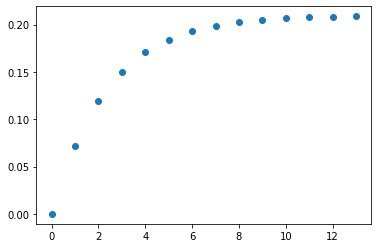

In [41]:
plt.scatter(range(len(theta_record)), theta_record)

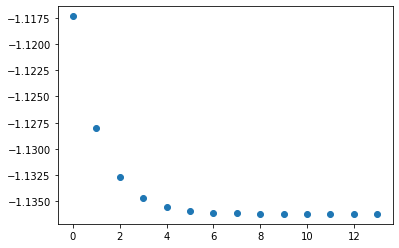

In [42]:
plt.scatter(range(len(energy_record)), energy_record)

What does the ground state look like?

In [43]:
@qml.qnode(dev)
def vqe_circuit(theta):
    initialize_state()
    variational_circuit(theta)
    return qml.state()

In [44]:
theta

tensor(0.20889103, requires_grad=True)

In [45]:
vqe_circuit(theta)

tensor([ 0.        +0.j,  0.        +0.j,  0.        +0.j,
        -0.10425572+0.j,  0.        +0.j,  0.        +0.j,
         0.        +0.j,  0.        +0.j,  0.        +0.j,
         0.        +0.j,  0.        +0.j,  0.        +0.j,
         0.99455052+0.j,  0.        +0.j,  0.        +0.j,
         0.        +0.j], requires_grad=True)

The ground state of $H_2$ is:

 \begin{equation}
|\Psi(\theta)\rangle = 0.99455052 |1100\rangle - 0.10425572 |0011\rangle
\end{equation}

## Shiny new sparse Hamiltonians!

<div class="alert alert-block alert-danger">
    The code in this section is currently only available in the development version of PennyLane! If you would like to try it out yourself, you will have to install PennyLane and qchem from the master branch of the <a href="https://github.com/PennyLaneAI/pennylane/">PennyLane Github repo</a>.
</div>

The Hamiltonian for $H_2$ is quite small. What happens with larger systems? We can greatly speed up calculation using a new feature of PennyLane: sparse Hamiltonians.

In [46]:
# H3+

basis_set = 'sto-3g'

electrons = 2
charge = 1
multiplicity = 1

active_electrons=2
active_orbitals=3

symbols = ["H", "H", "H"]
x = np.array([0.0057264744,   0.0235552275,   0.0000000000,
              0.5224560433,   0.8628483229,  -0.0000000000,
              0.9909174822,  -0.0043035504,   0.0000000000]) / 0.529177210903

In [47]:
H , qubits = qml.qchem.molecular_hamiltonian(
    symbols, 
    x, 
    charge=charge,
    mult=multiplicity,
    basis=basis_set,
    package='pyscf',
    active_electrons=active_electrons,
    active_orbitals=active_orbitals,
    mapping='jordan_wigner')


In [48]:
len(H.terms[0])

98

### Constructing the variational circuit

Let's use the Hartree-Fock state again as the starting state.

In [49]:
hf = qml.qchem.hf_state(active_electrons, active_orbitals * 2)
hf

array([1, 1, 0, 0, 0, 0])

In [50]:
def initialize_state():
    qml.BasisState(hf, wires=range(active_orbitals*2))

To construct the variational circuit, we choose the most general set of operations: all the single and double excitations.

Single excitations send

\begin{eqnarray}
|01\rangle &\rightarrow& \cos(\phi/2)|01\rangle + \sin(\phi/2)|10\rangle\\
|10\rangle &\rightarrow& \cos(\phi/2)|10\rangle - \sin(\phi/2) |01\rangle
\end{eqnarray}

We saw double excitations earlier; they send

\begin{eqnarray}
|0011\rangle &\rightarrow& \cos(\phi/2) |0011\rangle - \sin(\phi/2) |1100\rangle\\
|1100\rangle &\rightarrow& \cos(\phi/2) |1100\rangle + \sin(\phi/2) |0011\rangle 
\end{eqnarray}

With 8 electrons and 12 qubits, how can we implement all possible excitations? PennyLane has a built-in function for this as well: [`excitations()`](https://pennylane.readthedocs.io/en/stable/code/api/pennylane_qchem.qchem.excitations.html).

In [51]:
singles, doubles = qchem.excitations(active_electrons, active_orbitals * 2)

In [52]:
singles

[[0, 2], [0, 4], [1, 3], [1, 5]]

In [53]:
doubles[:5]

[[0, 1, 2, 3], [0, 1, 2, 5], [0, 1, 3, 4], [0, 1, 4, 5]]

Each excitation needs its own parameter. We can make our circuit ansatz now:

In [54]:
init_params = np.array([0.0] * (len(singles) + len(doubles)))

def variational_circuit(params):
    # All double excitations
    for i, d_wires in enumerate(doubles):
        qml.DoubleExcitation(params[i], wires=d_wires)
    
    # All single excitations
    for j, s_wires in enumerate(singles):
        qml.SingleExcitation(params[i+j+1], wires=s_wires)

Put these together to make the VQE circuit, and define a cost function. We do this in a special way using a sparse Hamiltonian:

In [55]:
H_sparse = qml.utils.sparse_hamiltonian(H)

In [56]:
H_sparse

<64x64 sparse matrix of type '<class 'numpy.complex128'>'
	with 368 stored elements in COOrdinate format>

In [57]:
def vqe_circuit(params):
    initialize_state()
    variational_circuit(params)
    return qml.expval(qml.SparseHamiltonian(H_sparse, wires=range(qubits)))

In [58]:
dev = qml.device("default.qubit", wires=active_orbitals*2)

qnode = qml.QNode(vqe_circuit, dev, diff_method='parameter-shift')

In [59]:
params = init_params.copy()

opt = qml.GradientDescentOptimizer(stepsize=0.5)

def cost(params):
    return qnode(params)

In [60]:
for n in range(20):
    t1 = time.time()
    params, energy = opt.step_and_cost(cost, params)
    t2 = time.time()
    print(f"n = {n},  E = {energy:.8f} H, t = {(t2-t1):.3f} S") 

AttributeError: module 'pennylane' has no attribute 'SparseHamiltonian'

## More things to try

 - run VQE for larger molecules
 - explore different variational circuit structures and initial states
 - try implementing extensions to VQE to find excited states
 - try a different optimization technique, such as the [quantum natural gradient](https://pennylane.ai/qml/demos/tutorial_vqe_qng.html)
 
More examples available in the [PennyLane demos](https://pennylane.ai/qml/demonstrations.html) (filter by "quantum chemistry" in the sidebar).